<a href="https://colab.research.google.com/github/khanma1962/Fire_Detection_Faster_RCNN/blob/main/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection Using Faster R-CNN

# Paper Referred

https://arxiv.org/pdf/1506.01497.pdf

### Github Repository
https://github.com/pytorch/vision/tree/master/references/detection

### Faster R-CNN Tutorial from
https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.kaggle.com/moekhan/pytorch-starter-fasterrcnn-train/edit

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py

# Labelling Tools used
https://github.com/tzutalin/labelImg

# Neural Network Traing Strategy
http://karpathy.github.io/2019/04/25/recipe/





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Calling Libraries

In [2]:
# clone the torchvision libraries
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [3]:
# Calling all the libraries
import numpy as np
import pandas as pd
import torch
import torchvision 
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
# from torchvision import engine
from engine import train_one_epoch, evaluate

import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os, sys, shutil, time 


torch.manual_seed(42)


In [4]:
# !pip install albumentations==0.4.6
# !pip install -U albumentations
!pip install --upgrade --force-reinstall --no-deps albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 

# https://github.com/albumentations-team/albumentations/blob/master/albumentations/pytorch/transforms.py#L74



  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3


In [5]:
# install specific pytorch - pytorch==1.3.1 torchvision==0.4.2

print(torch.__version__)
!python --version

1.9.0+cu102
Python 3.7.11


In [6]:
# checking for cuda
if (torch.cuda.is_available()):
    device = torch.device('cuda')
    print(f'device is {device} and device name is {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print(f'Connected to {str(device).upper()}')


device is cuda and device name is Tesla P100-PCIE-16GB


In [7]:
!nvidia-smi

Fri Jul 30 21:39:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    33W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
torch.cuda.memory_summary(device= None, abbreviated= False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [9]:
# Root directory for the project
ROOT_DIR = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/'
# ROOT_DIR = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data_10files'

# to find local version of the library
sys.path.append(ROOT_DIR)

# train and test dir
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/train/')
TEST_DIR  = os.path.join(ROOT_DIR, 'data/validation/')



# Dataset

In [10]:
# copy google drive files to colab directories

# start = time.time()
# if os.path.exists('/content/data/'):
#     shutil.rmtree('/content/data/')



# !rm -r /content/data/
# !cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/ .
# end = time.time()
# print(f'\nTotal time to transfer data is {end-start}  seconds\n')

# main_dir = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System'
# train_dir = '/content/data/train/images/'
# test_dir  = '/content/data/validation/images/'

#load csv with bounding details into pandas
train_df = pd.read_csv(os.path.join(TRAIN_DIR,'myvisionai_7_24_21_tr.csv'))
test_df = pd.read_csv(os.path.join(TEST_DIR, 'myvisionai_7_24_21_val.csv'))

print(f"Unique pics in train are {len(train_df['filename'].unique())}")
print(train_df.info(), '\n\n')

print(f"Unique pics in test are {len(test_df['filename'].unique())}")
print(test_df.info())


Unique pics in train are 412
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  563 non-null    object
 1   width     563 non-null    object
 2   height    563 non-null    object
 3   class     563 non-null    object
 4   xmin      563 non-null    int64 
 5   ymin      563 non-null    int64 
 6   xmax      563 non-null    int64 
 7   ymax      563 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 35.3+ KB
None 


Unique pics in test are 90
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  138 non-null    object
 1   width     138 non-null    object
 2   height    138 non-null    object
 3   class     138 non-null    object
 4   xmin      138 non-null    int64 
 5   ymin      138 non-null    

In [11]:
train_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,img (31).jpg,295,171,fire,5,40,81,95
1,img (32).jpg,undefined,undefined,fire,63,107,150,166
2,img (33).jpg,undefined,undefined,fire,153,114,218,153
3,img (34).jpg,undefined,undefined,fire,135,87,197,145
4,img (35).jpg,undefined,undefined,fire,206,11,288,73
...,...,...,...,...,...,...,...,...
558,small (133).jpg,undefined,undefined,fire,169,85,179,95
559,small (134).jpg,undefined,undefined,fire,151,100,166,115
560,small (135).jpg,undefined,undefined,fire,177,82,193,112
561,small (136).jpg,undefined,undefined,fire,90,66,112,101


In [12]:
# change xmin, ymin, xmax, and ymax as float
train_df['xmin'] = train_df['xmin'].astype(np.float)
train_df['xmax'] = train_df['xmax'].astype(np.float)
train_df['ymin'] = train_df['ymin'].astype(np.float)
train_df['ymax'] = train_df['ymax'].astype(np.float)

test_df['xmin'] = test_df['xmin'].astype(np.float)
test_df['xmax'] = test_df['xmax'].astype(np.float)
test_df['ymin'] = test_df['ymin'].astype(np.float)
test_df['ymax'] = test_df['ymax'].astype(np.float)

In [13]:
# checking number of files in train and test
for path, dir, fils in os.walk(os.path.join(TRAIN_DIR, 'images/')):
    print(f'{path} has {len(os.listdir(path))}')

for path, dir, fils in os.walk(os.path.join(TEST_DIR, 'images/')):
    print(f'{path} has {len(os.listdir(path))}')


/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/train/images/ has 412
/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/validation/images/ has 90


In [14]:
TRAIN_DIR

'/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/train/'

Image size is (191, 264, 3)


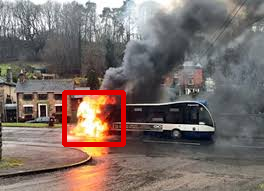

In [15]:
#plot a picture
pic_name = 'img (115).jpg' #'Fire_36.jpg'
image = cv2.imread(os.path.join(TRAIN_DIR, 'images', pic_name)) # 'images', pic_name))
print(f'Image size is {image.shape}')

xmin = train_df[train_df['filename']== pic_name]['xmin'].values
ymin = train_df[train_df['filename']== pic_name]['ymin'].values
xmax = train_df[train_df['filename']== pic_name]['xmax'].values
ymax = train_df[train_df['filename']== pic_name]['ymax'].values

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), color=(0,0,225 ), thickness=3)
cv2_imshow(image)


In [16]:
xmin

array([64.])

In [17]:
# Creating FireDataseet class
class FireDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms= None):
        super().__init__()

        self.df = dataframe
        self.image_dir = image_dir
        self.image_ids = dataframe['filename'].unique()
        # print(f'self.image_ids is {self.image_ids.shape}')
        # print('new dir is',self.image_dir)
        self.transforms = transforms

    def __getitem__(self, index: int):
        # print(f'index is {index} and image_id is {self.image_ids[index]}')
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]

        # read image into cv2 format
        # image = Image.open(os.path.join(self.image_dir, image)).convert("RGB")
        
        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.IMREAD_COLOR)#Image.open
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=  255.
        # print(f'image_dir is {self.image_dir}')#, image shape is {image.shape}, \n ')
       

        # find are based on xmin, ymin, xman, and yman
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # print(f'boxes is {boxes}')
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        # print(f'area is {area}')

        # conver boxes and are into tensors
        
        # boxes = torch.as_tensor(boxes, dtype= torch.float32)
        
        area  = torch.as_tensor(area, dtype=torch.float32)

        # there is one class only
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        # print('here')
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
       

        # create a dictionary target
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # print('there')

        # # transforms
        if self.transforms is not None:
            # image = self.transforms(image)
            sample = {'image': image,
                      'bboxes': target['boxes'],
                      'labels': labels
                      }
            sample = self.transforms(**sample)
            image = sample['image']
        
        # zip boxes, map as tensor, create tuple and stack
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]
        # return 10 # returns only 10 images - use it for overfitting the model



In [18]:
# Instead of transform running Albumentations

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



In [19]:

batch_size = 4
img_size = 100
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# collate function
# each element of dataset returns tupe(image, target) instead of a single value

def collate_function(batch):
    return tuple(zip(*batch))

# def get_transform(train):
#     transforms = []
#     # transforms.append(T.Resize(img_size)) # resize to avoid insufficient memory
#     # transforms.append(T.CenterCrop(img_size))
#     # conver PIL to Tensor
#     transforms.append(T.ToTensor())
#     if train:
#         # flip images during training 
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     return T.Compose(transforms)

# train and test datasets
train_dataset = FireDataset(train_df, os.path.join(TRAIN_DIR, 'images'), get_train_transform() )
test_dataset  = FireDataset(test_df, os.path.join(TEST_DIR, 'images'), get_test_transform() )
# train_dataset = FireDataset(train_df, TRAIN_DIR, get_train_transform() )



#train and test dataloader
train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers =2,
                               collate_fn = collate_function)

test_data_loader = DataLoader(test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers =2,
                               collate_fn = collate_function)


In [20]:
for images, targets in train_data_loader:
    break
print(f"image_0 is {images[0].shape}")
# print(f'image_1 is {images[1].shape}')
print(f'targets_0 are {targets[0]}')
# print(f'targets_1 are {targets[1]}\n\n')

image_0 is torch.Size([3, 183, 275])
targets_0 are {'boxes': tensor([[ 83.0000,  66.0000, 164.0000, 149.0000]], dtype=torch.float64), 'labels': tensor([1]), 'image_id': tensor([268]), 'area': tensor([6723.]), 'iscrowd': tensor([0])}


In [21]:
# def image_convert(image):
#     image = image.clone().cpu().numpy()
#     image = image.transpose((1, 2, 0))
#     image = (image * 255).astype(np.uint8)
#     return image

# def plot_image(data, idx):
#     out = data.__getitem__(idx)
#     print(f"image.shape is {out[0].shape}") #torch.Size([3, 183, 275])
#     image = image_convert(out[0])
#     image = np.ascontiguousarray(image) # returns ndarray contiguous
#     bb = out[1]['boxes'].numpy()
#     for i in bb:
#         cv2.rectangle(image, (i[0], i[1]), (i[2], i[3]), (225, 0 ,0), thickness=2)
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)

# plot_image(train_dataset, 9)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img has shape of (183, 275, 3)
boxes is [[ 85  14 211 100]]
dimension of boxeses  are 85, 14, 211, 100


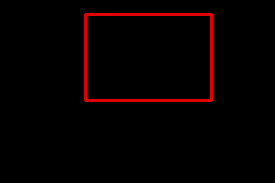

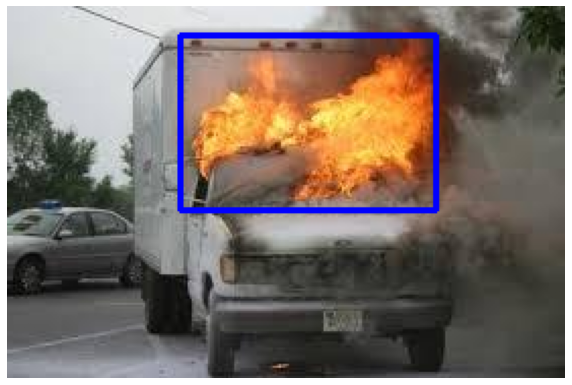

In [22]:
# let's see some images
# read first batch from train_data_loader
images, targets = next(iter(train_data_loader))

#send image to device
images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
targets = [{k: v.long().to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
xmin, ymin, xmax, ymax = boxes[0][0], boxes[0][1],boxes[0][2], boxes[0][3]

sample_tr = images[0].permute(1, 2, 0).cpu().numpy() # permute rearrange to 1,2,0 axis

print(f"img has shape of {sample_tr.shape}")
print(f"boxes is {boxes}")
print(f"dimension of boxeses  are {xmin}, {ymin}, {xmax}, {ymax}")


fig, ax = plt.subplots(1, 1, figsize=(10,8))

for box in boxes:
    cv2.rectangle(sample_tr,
                 (box[0], box[1]),
                 (box[2], box[3]), 
                # (5, 40), (81, 95),
                  color=(0, 0, 225),
                  thickness=2)

# for i in range(len(boxes)):
#     cv2.rectangle(sample_tr, 
#                   (boxes[i][0], boxes[i][1]),
#                   (boxes[i][2], boxes[i][3]),
#                   (0, 0 , 225), 3)


ax.set_axis_off()
ax.imshow(sample_tr)  #works but no bounding boxes

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
# sample_tr = cv2.rectangle(sample_tr, (xmin, ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(sample_tr); # blank screen - nothing display



# Pre-trained Model from torchvision


In [23]:
#Fine Tuning Pre-Trained Model
#load a pre-trained model with resnet50 as backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one
num_classes = 2 # 1 class(fire) and 0(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head wit the new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



# Train

In [24]:
# Training parameters
num_epochs = 100

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay= 0.005)
lr_scheduler = None
start_time = time.time()
total_train_loss = []

for epoch in range(num_epochs):
    star_time = time.time()
    train_loss = []
    model.train()

    for images, targets in train_data_loader:
        
        #send images and targets to device
        images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
        targets = [{k: v.long().to(device) for k,v in t.items()} for t in targets]


        loss_dict = model(images, targets)
        # print(f'loss dict is {loss_dict}')
        losses = sum(loss for loss in loss_dict.values())
        # print(f'diff losses are {loss_dict.keys()} ')
        train_loss.append(losses.item())
        # print(f"train losss is {train_loss}")

        optimizer.zero_grad() # to clear old gradient to zero
        losses.backward() # back prop for required_grade = True
        optimizer.step() # update parameter based on parameter.grad

    epoch_train_loss = np.mean(train_loss)
    # print(f"Epoch_train_loss is {epoch_train_loss}")
    total_train_loss.append(epoch_train_loss)
        
        #     print(f'Iterattion #{iter}  loss: {loss_value}')

        # itr += 1
        # if lr_scheduler is not None:
        #     lr_scheduler.step() # for adjusting the learning rate

    print(f'Epoch #{epoch+1} loss: {epoch_train_loss}')

    evaluate(model, test_data_loader, device=device )

end_time = time.time()
print(f"\n Total training time is {end_time - start_time} seconds \n")
# save model    
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch #1 loss: 0.2695520078962289
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:10  model_time: 0.3113 (0.3113)  evaluator_time: 0.0053 (0.0053)  time: 0.4676  data: 0.1483  max mem: 8284
Test:  [22/23]  eta: 0:00:00  model_time: 0.3081 (0.3329)  evaluator_time: 0.0071 (0.0073)  time: 0.3545  data: 0.0121  max mem: 8284
Test: Total time: 0:00:08 (0.3615 s / it)
Averaged stats: model_time: 0.3081 (0.3329)  evaluator_time: 0.0071 (0.0073)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.35

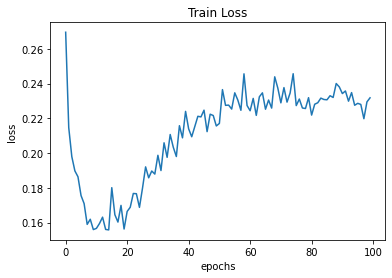

In [25]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Validation

Image size is (191, 264, 3)


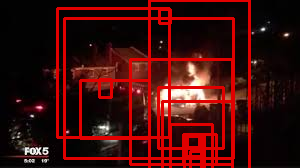

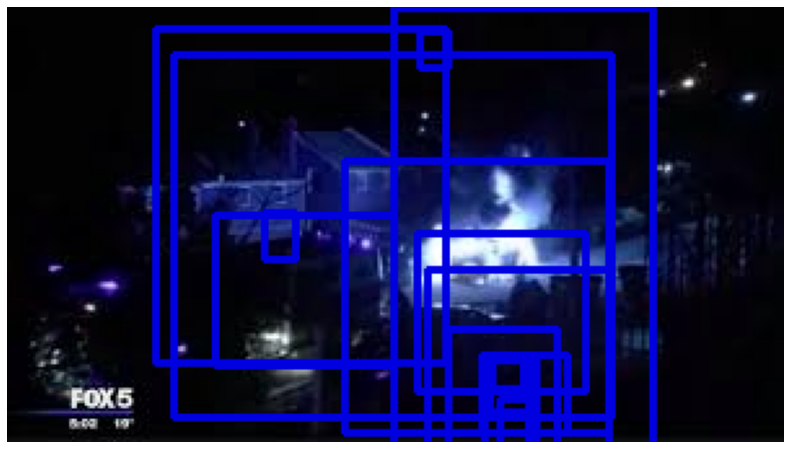

In [26]:
# Validation of model 

pic_name = 'img (11).jpg' #'Fire_36.jpg'
sample_val = cv2.imread(os.path.join(TEST_DIR, 'images', pic_name)) # 'images', pic_name))
print(f'Image size is {image.shape}')

# images, targets  = next(iter(test_data_loader)) # test_data_loader

# images = list(img.to(device) for img in images)
# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
# print(f"target is {targets}")
# boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
# sample_val = images[0].permute(1, 2, 0).cpu().numpy() # permute re-arrange the axes

#get the bounding box from model
model.eval()
cpu_device = torch.device('cpu')

outputs = []
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k,v in t.items()} for t in outputs]
# print(f"outputs is {outputs}")
outs_val = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize = (16,8))

for box in outs_val: #boxes:
    cv2.rectangle(sample_val,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 225),
                  2
                  )

ax.set_axis_off()
plt.imshow(sample_val)

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
# image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(sample_val);
